# import

In [11]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, mean_squared_error
from matplotlib import cm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

from new_rbfn import RBFNetwork
from new_jmlm import JMLM
from load_data import load_data

# init

In [17]:
root = f'D:/Applications/vscode/workspace/JMLM/outputs/'
n_samples, n_classes, hidden_dim, epoch_p, lr, std = 1000, 5, 10 , 1000, 0.5, 1
data_type = 1
update_type = 0

# load data

In [18]:
X, y = datasets.make_blobs(n_samples=n_samples, random_state=42, centers=n_classes, cluster_std=std)

# plot boundary function

In [19]:
def plot_boundary(meshgrid_data, xx, yy, X, y, y_train_preds, x_min, x_max, y_min, y_max, centers=None):
    fig, ax = plt.subplots(1, 2, figsize=(24, 10))
    cmap = cm.get_cmap('viridis', n_classes)
    ax[0].imshow(
        meshgrid_data,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=cmap,
        aspect="auto",
        origin="lower",
        alpha=0.8
    )  
    

    # plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)
    tmp = y == y_train_preds
    color =  [('black' if label else 'r')for label in tmp]
    ax[0].scatter(X[:,0], X[:,1], s=5, c=color)
    if centers:
        ax[0].scatter(centers[0], centers[1], s=50, c='w', marker="x", linewidths=3,)
        ax[1].scatter(centers[0], centers[1], s=50, c='black', marker="x", linewidths=3,)
        
    # ax[0].set_title(
    #     f"Meshgrid"
    # )
    
    for idx, cl in enumerate(np.unique(y)):
        ax[1].scatter(
            X[y == cl][:,0], 
            X[y == cl][:,1],
            alpha=0.8, 
            c= cmap(cl / n_classes),
            marker='o', 
            label=cl, 
            s=5
        )
    ax[0].set_xlim(x_min, x_max)
    ax[0].set_ylim(y_min, y_max)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    plt.close()

In [20]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.01  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# RBF

In [21]:
data_type_list = {0: "fixed", 1: "updated", 2: "all"}
update_type_list = {0: "one", 1: "cluster"}
result = f""
result += f"{data_type_list[data_type] = }\n{update_type_list[update_type] = }\n{n_samples = }\n{n_classes = }\n{hidden_dim = }\n{epoch_p = }\n"
X, y = datasets.make_blobs(n_samples=n_samples, random_state=42, centers=n_classes, cluster_std=std)
draw_X, draw_y = X, y
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

rbfn = RBFNetwork(hidden_dim=hidden_dim, n_max_center=20, threshold=0.1, epoch=10, epoch_p=epoch_p, lr=lr, root=root, data_type=data_type, update_type=update_type)
rbfn = rbfn.fit(X, y)

y_train_preds = rbfn.predict(X)
train_acc = accuracy_score(y, y_train_preds)
print(f"{train_acc = }")

==============layer = 0==============
len(train_data) = 1


100%|██████████| 1000/1000 [02:31<00:00,  6.61it/s]

current n centers: 10
train_acc = 0.749


In [22]:
# Obtain labels for each point in mesh. Use last trained model.
RBF_Z = np.array(rbfn.predict(np.c_[xx.ravel(), yy.ravel()]))

# Put the result into a color plot
RBF_Z = RBF_Z.reshape(xx.shape)

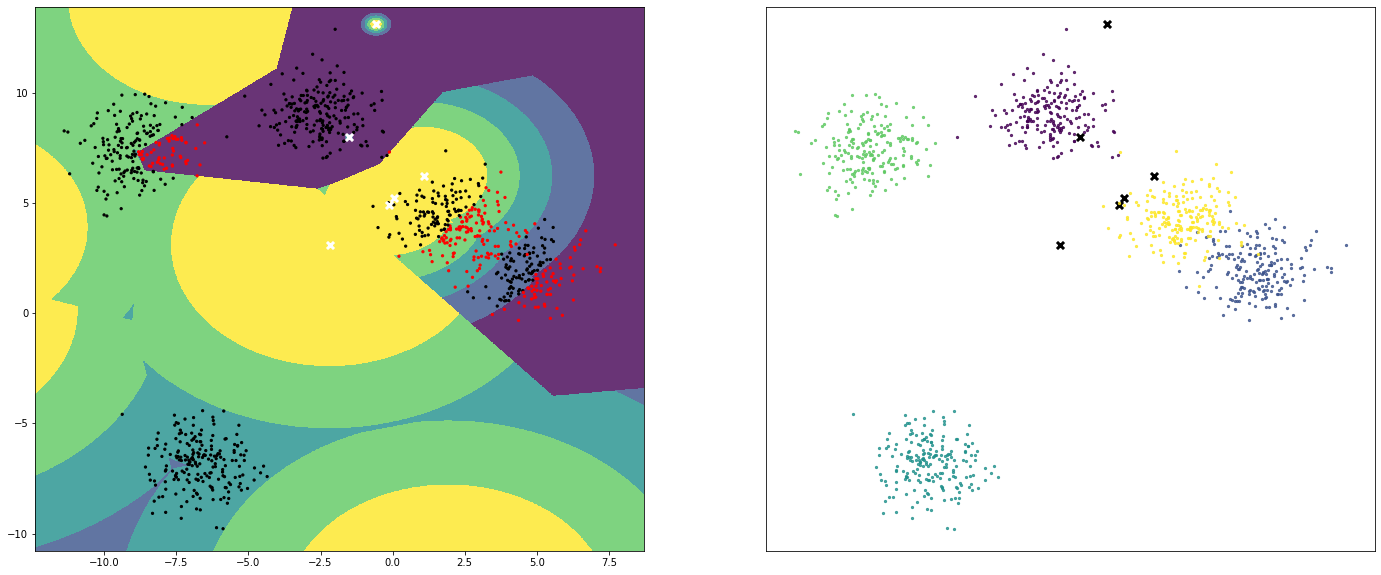

In [23]:
centers = [rbfn.centers[:,0], rbfn.centers[:,1]]
plot_boundary(RBF_Z, xx, yy, X, y, y_train_preds, x_min, x_max, y_min, y_max, centers=centers)

# JMLM

In [24]:
types = ["JMLM", "Deep", "old"]
training_type = "JMLM"
threshold = 0.01
to_max = False
kmeans_iter = 10
onehotencoder = OneHotEncoder()
y = onehotencoder.fit_transform(y.reshape(-1, 1)).toarray()

jmlm = JMLM()
acc_list, knn_acc_list, mse_list = jmlm.jmlm_train(X, y, max_points=hidden_dim, threshold=threshold, to_max=to_max, kmeans_iter=kmeans_iter)
y_train_pred, y_train_knn_pred = jmlm.predict(X)

knn_acc_train = accuracy_score(y, y_train_knn_pred)
acc_train = accuracy_score(y.argmax(axis=1), y_train_pred)
print(f"{acc_train = }")


100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

(800, 2)
acc_train = 0.979


In [25]:
JMLM_Z, _ = jmlm.predict(np.c_[xx.ravel(), yy.ravel()])
JMLM_Z = JMLM_Z.reshape(xx.shape)

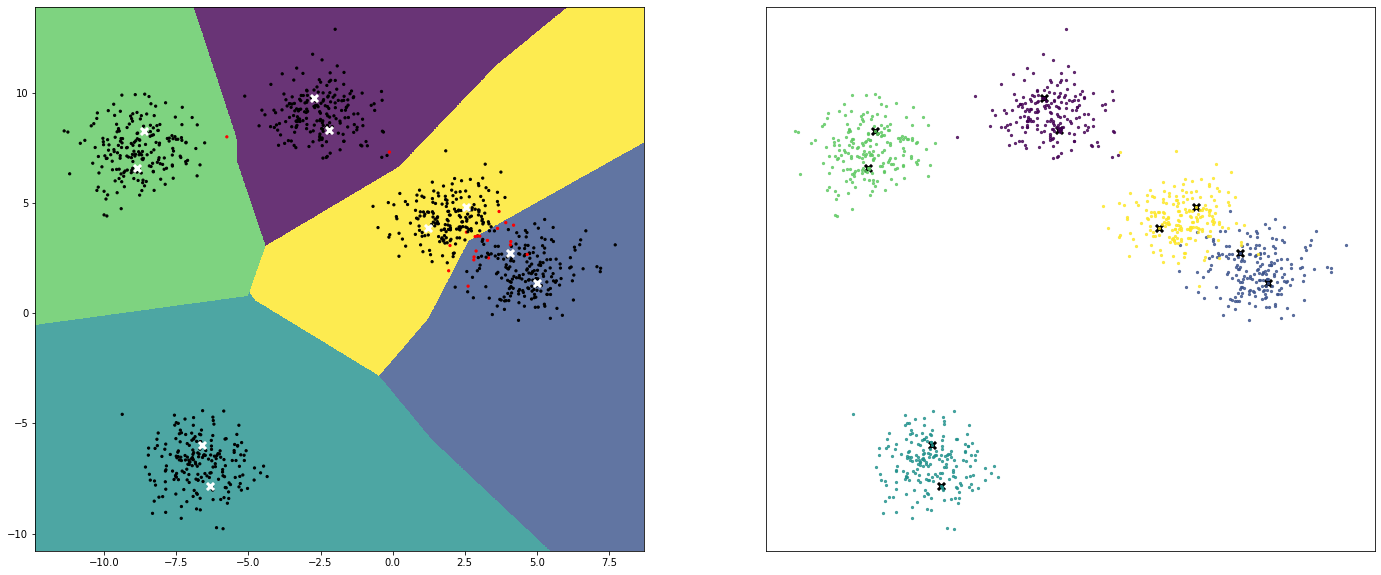

In [26]:
plot_boundary(JMLM_Z, xx, yy, X, y.argmax(axis=1), y_train_pred, x_min, x_max, y_min, y_max, centers=[np.array(jmlm.points)[:,0], np.array(jmlm.points)[:,1]])

# MLP

In [27]:
mlp = MLPClassifier(max_iter=3000).fit(X, y)
# mlp = MLPClassifier(random_state=1, max_iter=3000).fit(X, y)
y_train_mlp_pred = mlp.predict(X)
mlp_acc_train = accuracy_score(y, y_train_mlp_pred)
print(f"{mlp_acc_train = }")

mlp_acc_train = 0.977


In [28]:
MLP_Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])
MLP_Z = MLP_Z.argmax(axis=1).reshape(xx.shape)

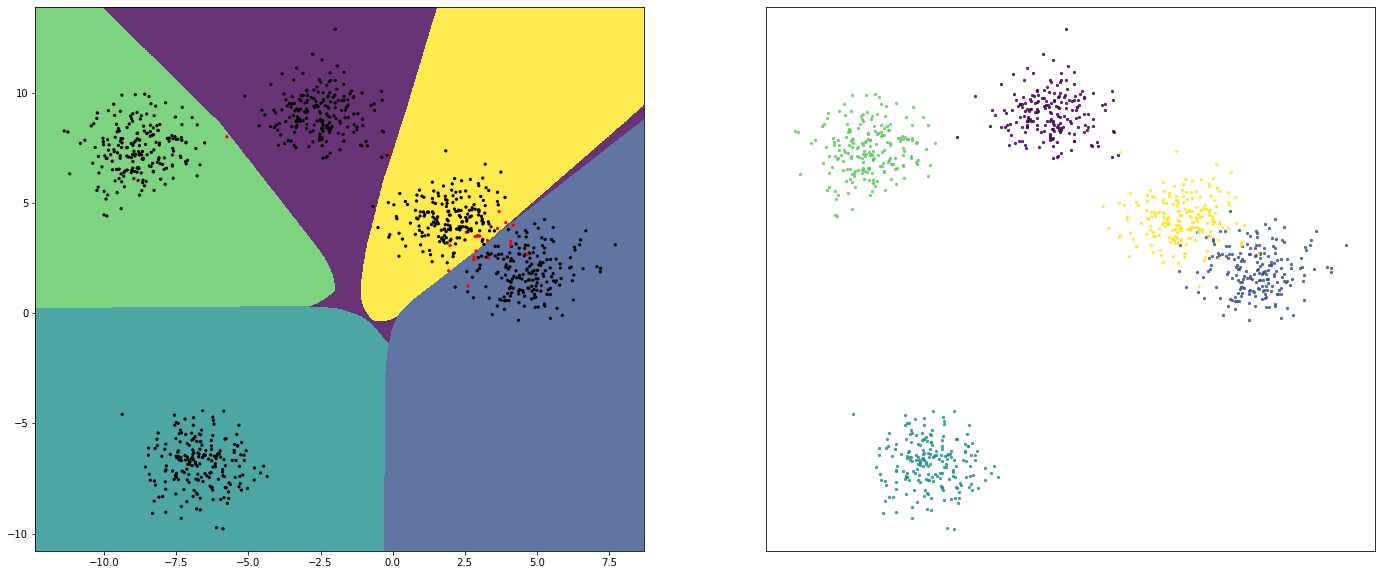

In [29]:
plot_boundary(MLP_Z, xx, yy, X, y.argmax(axis=1), y_train_pred, x_min, x_max, y_min, y_max)

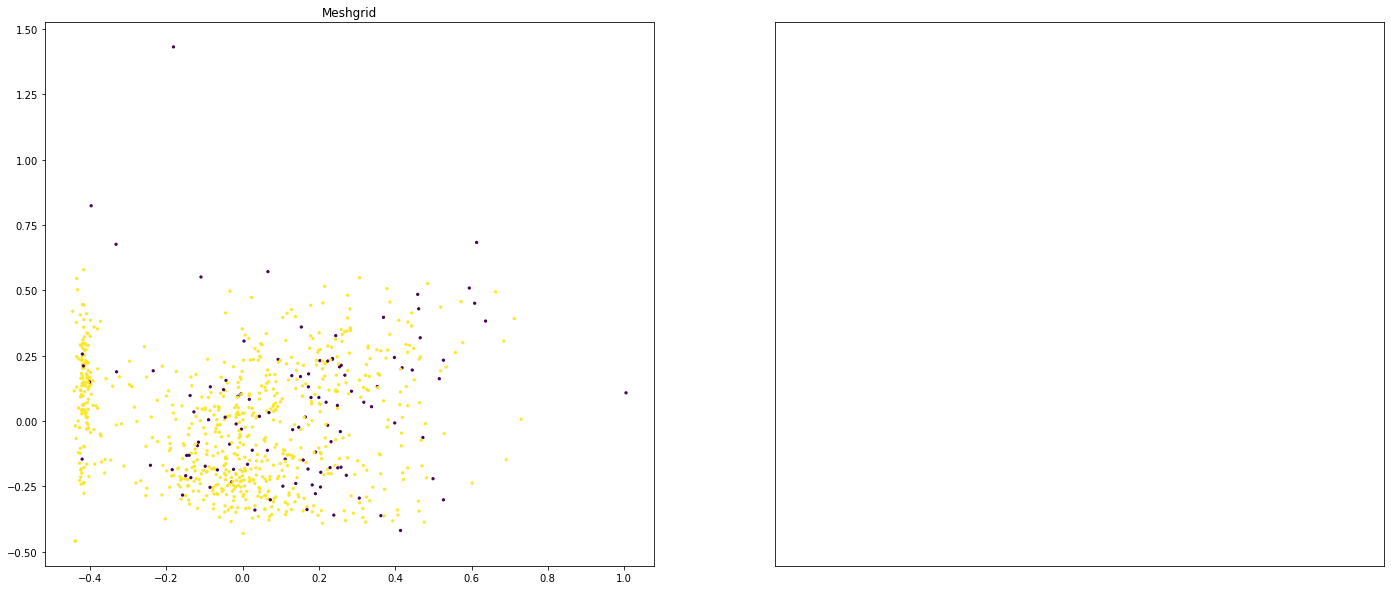

In [30]:
dataset = 'ICU'
X_train, X_test, y_train, y_test = load_data(dataset, onehot=False)

pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

fig, ax = plt.subplots(1, 2, figsize=(24, 10))
 


# # plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)
# tmp = y == y_train_preds
# color =  [('black' if label else 'r')for label in tmp]
ax[0].scatter(X_pca[:,0], X_pca[:,1], s=5, c=y_train)
# if centers:
#     plt.scatter(centers[0], centers[1], s=50, c='w', marker="x", linewidths=3,)
    
ax[0].set_title(
    f"Meshgrid"
)

# for idx, cl in enumerate(np.unique(y)):
    # ax[1].scatter(
    #     X[y == cl][:,0], 
    #     X[y == cl][:,1],
    #     alpha=0.8, 
    #     c= cmap(cl / n_classes),
    #     marker='o', 
    #     label=cl, 
    #     s=5
    # )
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()
plt.close()


In [33]:

asmpt_target = 0
data = pd.read_csv("D:/Applications/vscode/workspace/JMLM/datasets/asmpt/Train.csv")
Train_data = data.loc[data['TrainTest'] == 'Train']
Test_data = data.loc[data['TrainTest'] == 'Test']
X_train = Train_data.loc[:,Train_data.columns.str.startswith('feature_')].to_numpy()
y_train = Train_data['target_' + str(asmpt_target)].to_numpy()
X_test = Test_data.loc[:,Test_data.columns.str.startswith('feature_')].to_numpy()
y_test = Test_data['target_' + str(asmpt_target)].to_numpy()
print(f"{X_train.shape = }")
print(f"{y_train.shape = }")
print(f"{X_test.shape = }")
print(f"{y_test.shape = }")
X_train

X_train.shape = (52365, 156)
y_train.shape = (52365,)
X_test.shape = (16999, 156)
y_test.shape = (16999,)


array([[1.799700e+02, 4.005000e+01, 9.487820e+03, ..., 7.272730e+02,
        7.422000e+00, 2.188000e+00],
       [1.799700e+02, 4.005000e+01, 9.488610e+03, ..., 7.272730e+02,
        6.166000e+00, 1.875000e+00],
       [1.799700e+02, 4.005000e+01, 8.761500e+03, ..., 7.272730e+02,
        7.195000e+00, 2.125000e+00],
       ...,
       [1.800190e+02, 4.002100e+01, 2.445766e+03, ..., 7.272730e+02,
        7.750000e+00, 2.250000e+00],
       [1.800190e+02, 4.002100e+01, 2.440227e+03, ..., 7.272730e+02,
        8.042000e+00, 2.313000e+00],
       [1.800190e+02, 4.002100e+01, 8.048055e+03, ..., 7.272730e+02,
        8.028000e+00, 2.313000e+00]])

In [34]:
reg = LinearRegression(fit_intercept=True).fit(X_train, y_train)
score = reg.score(X_train, y_train)
train_pred = reg.predict(X_train)
test_pred = reg.predict(X_test)
train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)


print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

Train MSE: 1.060533240307093
Test MSE: 10992.014142005677


In [35]:
score

0.4791372313161214

Mean squared error: 0.00


Text(0.5, 1.0, 'Experience Vs. Salary')

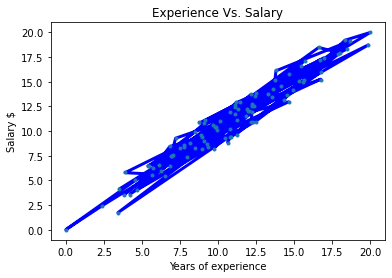

In [17]:
x, y, coef = datasets.make_regression(n_samples=100,#number of samples
                                      n_features=1,#number of features
                                      n_informative=1,#number of useful features 
                                      noise=10,#bias and standard deviation of the guassian noise
                                      coef=True,#true coefficient used to generated the data
                                      random_state=0) #set for same data points for each run

# Scale feature x (years of experience) to range 0..20
x = np.interp(x, (x.min(), x.max()), (0, 20))

# Scale target y (salary) to range 20000..150000 
y = np.interp(y, (y.min(), y.max()), (0, 20))

# reg = LinearRegression()
# reg.fit(x, y)
# y_pred = reg.predict(x)

xgb = XGBRegressor()
xgb.fit(x, y)
y_pred = xgb.predict(x)


print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
plt.plot(x, y_pred, color="blue", linewidth=3)


plt.ion() #interactive plot on
plt.plot(x, y,'.',label='training data')
plt.xlabel('Years of experience');plt.ylabel('Salary $')
plt.title('Experience Vs. Salary')

In [16]:
from reg_jmlm import JMLM

n_max_node = 10
threshold = 0.01
kmeans_iter = 10
asmpt_target = 5

jmlm = JMLM()
jmlm.train(x, y, x, y, n_max_node, threshold, False, kmeans_iter)

y_pred = jmlm.predict(x)
print(f"Train MSE: {mean_squared_error(y, y_pred)}")

100%|██████████| 10/10 [00:03<00:00,  2.82it/s]

Train MSE: 1.7538710316313333


Text(0.5, 1.0, 'Experience Vs. Salary')

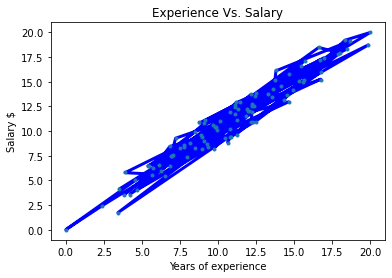

In [18]:
plt.plot(x, y_pred, color="blue", linewidth=3)
plt.ion() #interactive plot on
plt.plot(x, y,'.',label='training data')
plt.xlabel('Years of experience');plt.ylabel('Salary $')
plt.title('Experience Vs. Salary')

In [15]:
for target in range(0, 6):
    X_train, X_test, y_train, y_test = load_data("asmpt_train", onehot=False, normalization=False, asmpt_target=target, classification=False)
    xgb = XGBRegressor()
    xgb.fit(X_train, y_train)
    y_train_pred = xgb.predict(X_train)
    y_test_pred = xgb.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    print(f"target_{target}:\n\tTrain MSE: {train_mse}\n\tTest MSE: {test_mse}")


target_0:
	Train MSE: 0.3368409948520217
	Test MSE: 0.5769962845054283
target_1:
	Train MSE: 0.23518793317439934
	Test MSE: 0.46497772798741716
target_2:
	Train MSE: 0.2795766394181733
	Test MSE: 0.41921908318541334
target_3:
	Train MSE: 0.45786605538075
	Test MSE: 0.8481521811295879
target_4:
	Train MSE: 0.5650300184456201
	Test MSE: 0.8833307634141112
target_5:
	Train MSE: 0.04843828363843
	Test MSE: 0.09301530416394535


Mean squared error: 0.34


Text(0.5, 1.0, 'Experience Vs. Salary')

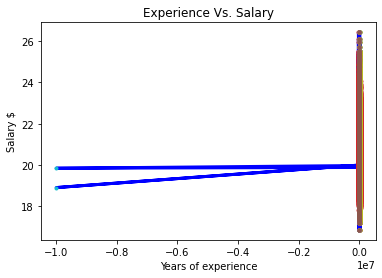

In [14]:
print("Mean squared error: %.2f" % mean_squared_error(y_train, y_train_pred))
plt.plot(X_train, y_train_pred, color="blue", linewidth=3)


plt.ion() #interactive plot on
plt.plot(X_train, y_train_pred,'.',label='training data')
plt.xlabel('Years of experience');plt.ylabel('Salary $')
plt.title('Experience Vs. Salary')